# HW02 - Visualizing features of a pretrained VGG
In this homework, we are going to try to visualize what neurons encode through optimization.

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


First, load the pretrained VGG model with torchvision, and print the architecture of the model.

In [ ]:
vgg = models.vgg16(pretrained=True)
print(vgg)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Part A - Visualizing the convolution filters

First, plot all the filters for the red channel of the first convolutional layer (there should be 64 filters in total). Can you find filters that seem to encode edges? Is this method useful for other layers?

In [ ]:
first_conv_layer = vgg.features[0]
weights = first_conv_layer.weight.data.cpu().numpy()

fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i in range(8):
    for j in range(8):
        filter_index = i * 8 + j
        axes[i, j].imshow(weights[filter_index, 0, :, :], cmap='gray')  #red channel
        axes[i, j].axis('off')
plt.show()


There are filters like the 1st and 5th with clear vertical and horizontal lines, and others with defined corners like the 4th or the 17th, which seem to encode edges. These edge encoding filters are evident in the first layer because the model learns simple features and low-level information. However in deeper layers, filters encode more complex and high-level info, which would not be easily interpretable visually by simply plotting the filters.

# Part B - Visualizing channel activations through image optimization
## B.1 - First implementation
Create a module `ChannelActivation(layer, channel)` that returns the average activation (i.e. output value) of channel `channel` of layer `layer` of the VGG features.

In [ ]:
class ChannelActivation:
    def __init__(self, model):
        self.model = model.to(device)
        self.model.eval()

    def get_activation(self, x, layer, channel):
        activations = []

        def hook(model, input, output):
            activations.append(output)  # Do NOT detach to keep computation graph!

        hook_handle = self.model.features[layer].register_forward_hook(hook)

        _ = self.model(x)  # Forward pass

        hook_handle.remove()

        if not activations:
            return torch.tensor(0.0, device=x.device, requires_grad=True)

        return activations[0][0, channel, :, :].mean()  # Keep requires_grad=True



Our objective is to find which patterns are recognized by a given channel. To do so, we will follow the approach of [this Distill article](https://distill.pub/2017/feature-visualization/) and find images that lead to the highest possible channel activation.

First, create a random (colored) image of size 128x128, initialized with value at random between 0.4 and 0.6 (i.e. grey + small perturbation). Then, perform 200 steps of Adam (with lr=0.01) to maximize the activation of channel 4 of layer 1. Plot the image after 0, 10, 50, 100 and 200 iterations. You should see a pink saturated image with several horizontal lines, indicating that the channel probably recognizes horizontal edges.

**NB1:** Careful, by default, optimizers minimize their objective, not maximize it!

**NB2:** The parameters given to an optimizer should be on the cpu. If you use a gpu, you thus need to keep two versions of the image: 1) a cpu version given to the optimizer, and 2) a gpu version, created at each iteration of the optimization, and used to compute the gradient.

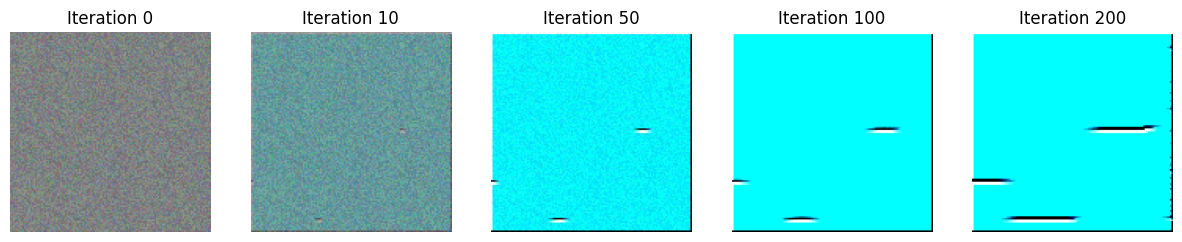

In [ ]:
input_image = torch.rand(1, 3, 128, 128) * (0.6 - 0.4) + 0.4
input_image.requires_grad = True
optimizer = torch.optim.Adam([input_image], lr=0.01)
iterations = [0, 10, 50, 100, 200]
fig, axes = plt.subplots(1, len(iterations), figsize=(15, 5))
for i in range(201):
    optimizer.zero_grad()
    input_image_gpu = input_image.to(device)
    activation = ChannelActivation(vgg).get_activation(input_image_gpu, 1, 4)
    loss = -activation
    loss.backward()
    optimizer.step()
    if i in iterations:
        idx = iterations.index(i)
        axes[idx].imshow(input_image.detach().cpu().squeeze(0).permute(1, 2, 0))
        axes[idx].set_title(f"Iteration {i}")
        axes[idx].axis("off")
plt.show()

## B.2 - Improving stability with clipping and normalization
Compute the highest and lowest values of the image. What is the issue?

In [ ]:
print(torch.min(input_image))
print(torch.max(input_image))

tensor(-2.4784, grad_fn=<MinBackward1>)
tensor(3.5860, grad_fn=<MaxBackward1>)


The pixel values are outside the [0,1] range expected by VGG16. The optimzer pushes pixel values beyond valid intensities: oversaturation

To avoid (over) saturation, clip the image pixels to $[0.2,0.8]$ after each optimization step using `input_image.data = input_image.data.clip(0.2, 0.8)`. You should now see several clear horizontal lines in a blue background.

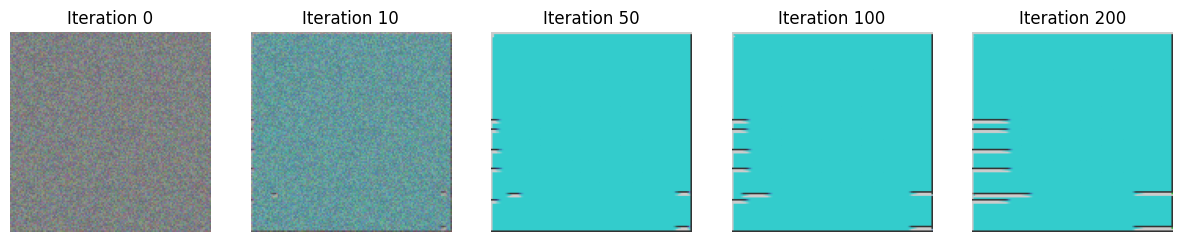

In [ ]:
input_image = torch.rand(1, 3, 128, 128) * (0.6 - 0.4) + 0.4
input_image.requires_grad = True
optimizer = torch.optim.Adam([input_image], lr=0.01)
iterations = [0, 10, 50, 100, 200]
fig, axes = plt.subplots(1, len(iterations), figsize=(15, 5))
for i in range(201):
    optimizer.zero_grad()
    input_image_gpu = input_image.to(device)
    activation = ChannelActivation(vgg).get_activation(input_image_gpu, 1, 4)
    loss = -activation
    loss.backward()
    optimizer.step()

    input_image.data = input_image.data.clip(0.2, 0.8)

    if i in iterations:
        idx = iterations.index(i)
        axes[idx].imshow(input_image.detach().cpu().squeeze(0).permute(1, 2, 0))
        axes[idx].set_title(f"Iteration {i}")
        axes[idx].axis("off")
plt.show()

One issue with our current code, is that VGG was trained on **normalized** images, and thus is not adapted to our input image. To normalize the image, we will use **transforms**.

Create a function `create_activation_image(layer, channel, transform=None, image_size=128, show_steps=False)` that maximizes the corresponding channel activation on an image of size `image_size`, and first applies `transform` to the image before computing the gradient of the activation. The function should return the final image after 200 steps, and plot intermediate images for the steps 0,10,50,100,200 if `show_steps=True`.

Then, test your function with `transform=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`. Is this better? You should now see a horizontal pattern with lines.

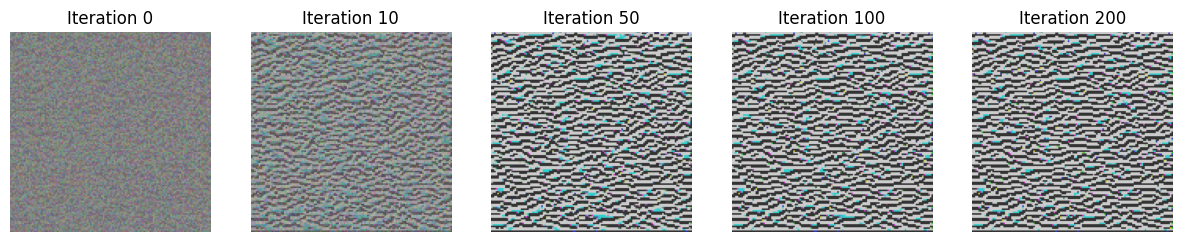

In [ ]:
def create_activation_image(layer, channel, transform=None, image_size=128, show_steps=False):
    input_image = torch.rand(1, 3, image_size, image_size) * (0.6 - 0.4) + 0.4
    input_image.requires_grad = True
    optimizer = torch.optim.Adam([input_image], lr=0.01)
    iterations = [0, 10, 50, 100, 200]

    if show_steps:
        fig, axes = plt.subplots(1, len(iterations), figsize=(15, 5))

    for i in range(201):
        optimizer.zero_grad()
        input_image_gpu = input_image.to(device)

        if transform:
            input_image_gpu = transform(input_image_gpu)

        activation = ChannelActivation(vgg).get_activation(input_image_gpu, layer, channel)
        loss = -activation
        loss.backward()
        optimizer.step()

        input_image.data = input_image.data.clip(0.2, 0.8)

        if show_steps and i in iterations:
            idx = iterations.index(i)
            axes[idx].imshow(input_image.detach().cpu().squeeze(0).permute(1, 2, 0))
            axes[idx].set_title(f"Iteration {i}")
            axes[idx].axis("off")

    if show_steps:
        plt.show()
    return input_image


normalized_image = create_activation_image(1, 4, transform=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), show_steps=True)


Now test your function on channel 0 of layer 20. The pattern that appears should vagely resemble fish scales.

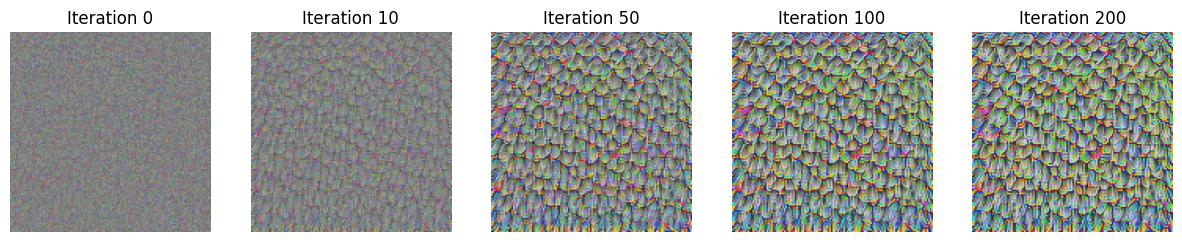

In [ ]:
normalized_image = create_activation_image(20, 0, transform=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), show_steps=True)

## B.3 - Transformation robustness
Large neural network are prone to adversarial attacks, i.e. a small well-crafted additive noise can dramatically change the output of the model, and thus lead to incorrect classification. For our purpose, this is an issue, as the optimization algorithm may find such very specific noise instead of more valuable visual patterns.

To avoid this issue and further improve our images, we are thus going to apply small random perturbations to the image before computing the gradient. This will prevent the optimizer from optimizing the noise, and overall increase the stability of our process.

To do so, add a composition of several transforms (before the normalization):

1.   A small pixel noise with `transforms.Lambda(lambda x: x + 0.001 * (2 * torch.rand_like(x) - 1))`
2.   A random affine transform with `transforms.RandomAffine(degrees=5, translate=(0.1,0.1), scale=(0.9,1.1))`
3.   A random crop of size 96 (to reduce the size of the image)
4.   Random local fluctations with `transforms.ElasticTransform(alpha=50.)`

Compare the activation images with and without these random transformations. Is the pattern more visible?



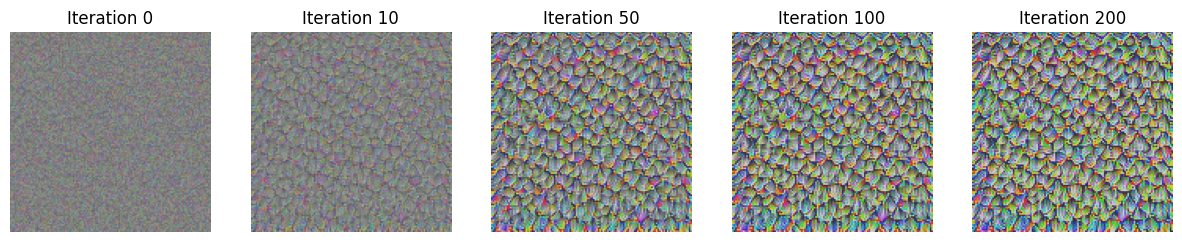

In [ ]:
transform_pipeline = transforms.Compose([
    transforms.Lambda(lambda x: x + 0.001 * (2 * torch.rand_like(x) - 1)),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomCrop(96),
    transforms.ElasticTransform(alpha=50.),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#with random transformations
transformed_image = create_activation_image(20, 0, transform=transform_pipeline, image_size=128, show_steps=True)
#without random transformations
normalized_image = create_activation_image(20, 0, transform=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), show_steps=True)

The activation images with the random transformations are smoother and the fish scale pattern is more visible and natural whereas the images without are more "pixelized" and blurry

To see what the transformation is doing to an image, apply the random transformations (without normalization) to the following simple image, and show 5 randomly transformed images.

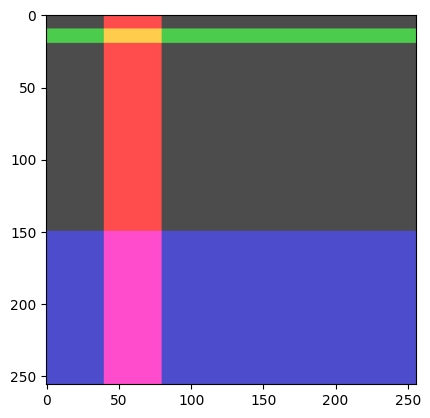

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor.detach().cpu().squeeze(0).permute(1, 2, 0)
    tensor = tensor.clip(0,1)
    return tensor

sample_image = 0.3 * torch.ones(3, 256, 256)
sample_image[0,:,40:80] += 0.7
sample_image[1,10:20,:] += 0.5
sample_image[2,150:,:] += 0.5
plt.imshow(tensor_to_image(sample_image))

transform_wo_norm = transforms.Compose([
    transforms.Lambda(lambda x: x + 0.001 * (2 * torch.rand_like(x) - 1)),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomCrop(96),
    transforms.ElasticTransform(alpha=50.)
])


fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    transformed_sample = transform_pipeline(sample_image)
    axes[i].imshow(tensor_to_image(transformed_sample))
    axes[i].axis('on')
plt.show()



## B.4 - Final visualization
Finally, show the activation images for the first 5 channels of layers [1, 10, 20, 30]. You should be able to see a gradual complexification of the patterns.

**PS1:** Our method seems unable to find meaningful patterns for the last layer. One issue is probably that the random crop imposes that all regions on the image look similar (as they all should have a high channel activation), thus preventing larger and more complex patterns to emerge from the optimization.

**PS2:** You can also try other layers and channels to find interesting patterns!

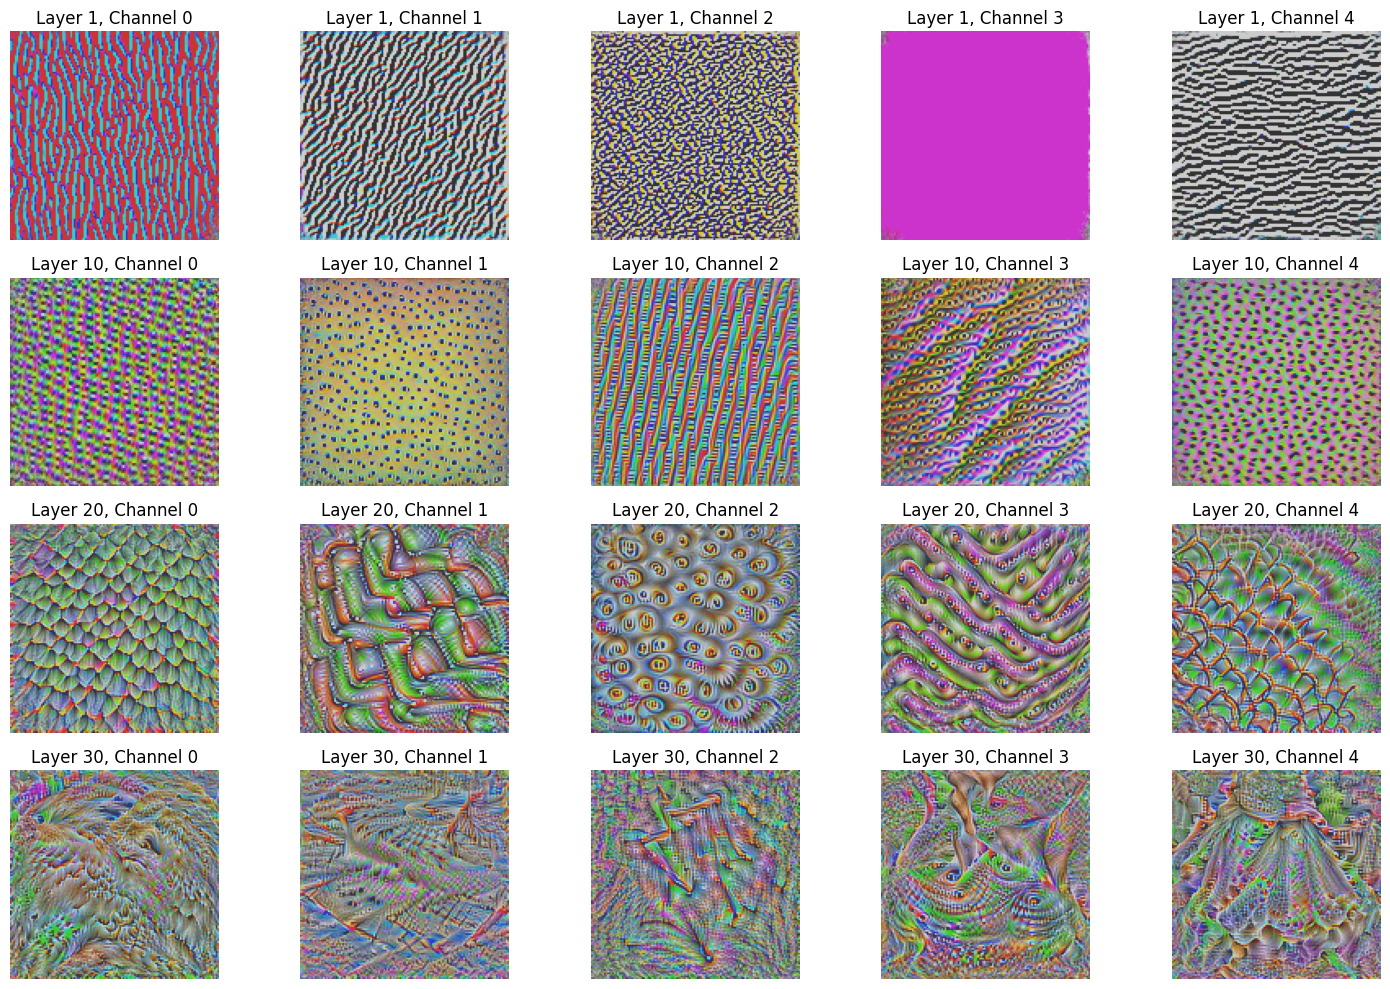

In [ ]:
layers = [1, 10, 20, 30]
channels = range(5)


fig, axes = plt.subplots(len(layers), len(channels), figsize=(15, 10))

for i, layer in enumerate(layers):
    for j, channel in enumerate(channels):
        activation_image = create_activation_image(layer, channel, transform=transform_pipeline, image_size=128)
        axes[i, j].imshow(tensor_to_image(activation_image))
        axes[i, j].set_title(f"Layer {layer}, Channel {channel}")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()